# Regional Maps
Generate maps

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
from scipy.stats import binned_statistic, binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from src.regions import *
from src.pf_stats import *
from src.plotting import *


## CDF of MaxPR

Text(0.5, 1.0, 'GPM PF MaxPr, Cumulative Distribution Function')

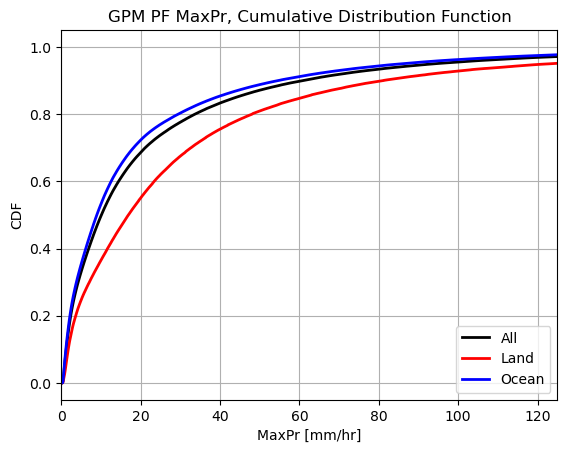

In [3]:
regions = [sam_region(), afc_region(), cio_region(), wmp_region(), h01_region(), h05_region(), sas_region(), epo_region()]
max_pr_arr = np.array([])
is_land_arr = np.array([])
for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    max_pr = pf_stats.max_precip.values
    lat = pf_stats.mean_latitude.values
    lon = pf_stats.mean_longitude.values
    assert(max_pr.size==lat.size==lon.size)
    max_pr_arr = np.concatenate((max_pr_arr, max_pr))
    is_land = globe.is_land(lat=lat, lon=lon)
    is_land_arr = np.concatenate((is_land_arr, is_land))

def get_land_data(x):
    return x[np.where(is_land_arr)]
def get_ocean_data(x):
    return x[np.where(~is_land_arr)]
fig, ax = plt.subplots()

land_max_pr = max_pr_arr[np.where(is_land_arr==1)]
ocean_max_pr = max_pr_arr[np.where((is_land_arr==0))]

sorted_max_pr = np.sort(max_pr_arr)
sorted_land_max_pr = np.sort(land_max_pr)
sorted_ocean_max_pr = np.sort(ocean_max_pr)

# All data
cdf = np.linspace(1, sorted_max_pr.size, sorted_max_pr.size)/sorted_max_pr.size
ax.plot(sorted_max_pr, cdf, color='black', lw=2, label='All')

land_cdf = np.linspace(1, sorted_land_max_pr.size, sorted_land_max_pr.size)/sorted_land_max_pr.size
ax.plot(sorted_land_max_pr, land_cdf, color='red', lw=2, label='Land')

ocean_cdf = np.linspace(1, sorted_ocean_max_pr.size, sorted_ocean_max_pr.size)/sorted_ocean_max_pr.size
ax.plot(sorted_ocean_max_pr, ocean_cdf, color='blue', lw=2, label='Ocean')

ax.legend(loc='lower right')
ax.grid()
ax.set_xlim(0, 125)
ax.set_xlabel('MaxPr [mm/hr]')
ax.set_ylabel('CDF')
ax.set_title('GPM PF MaxPr, Cumulative Distribution Function')

## Maps of EPFs

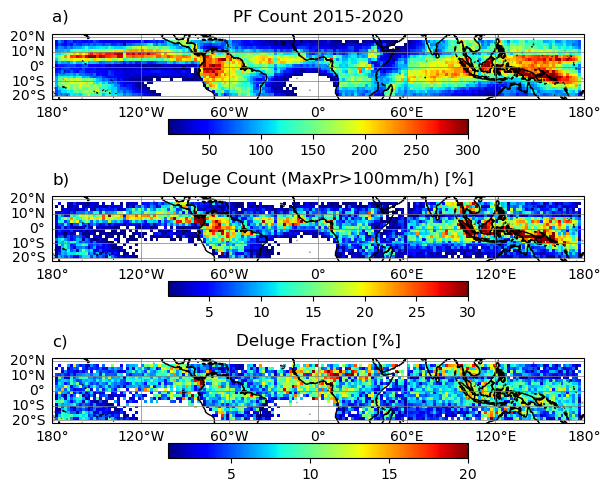

In [4]:
regions = [sam_region(), afc_region(), cio_region(), wmp_region(), h01_region(), h05_region(), sas_region(), epo_region()]
thresh = 100
lat_bins = np.arange(-20, 20, 2)
lon_bins = np.arange(-180, 180, 2)
lat_midpoints = (lat_bins[1:] + lat_bins[:-1])/2
lon_midpoints = (lon_bins[1:] + lon_bins[:-1])/2
lon_mesh, lat_mesh = np.meshgrid(lon_midpoints, lat_midpoints)

# initialize arrays: num of observations, num of deluges, and mean precip of pfs
obs_count = np.full_like(lon_mesh, fill_value=0)
deluges_counts = np.full_like(lon_mesh, fill_value=0)
pr_accum = np.full_like(lon_mesh, fill_value=0)
deluge_accum = np.full_like(lon_mesh, fill_value=0)
pixel_accum = np.full_like(lon_mesh, fill_value=0)

for region in regions:
    pf_stats = load_pf_stats(region, trim_region=True)
    
    # Plot the number of extreme PFs
    max_pr = pf_stats.max_precip
    deluge_id = max_pr>=thresh
    lat, lon = pf_stats.mean_latitude, pf_stats.mean_longitude
    obs_count += binned_statistic_2d(lat, lon, None, statistic='count', bins=[lat_bins, lon_bins]).statistic
    deluges_counts += binned_statistic_2d(lat.where(deluge_id), lon.where(deluge_id), None, statistic='count', bins=[lat_bins, lon_bins]).statistic
    deluge_accum += binned_statistic_2d(lat.where(deluge_id), lon.where(deluge_id), pf_stats.total_precip.where(deluge_id), statistic='count', bins=[lat_bins, lon_bins]).statistic
    pr_accum += binned_statistic_2d(lat, lon, pf_stats.total_precip, statistic='sum', bins=[lat_bins, lon_bins]).statistic
    pixel_accum += binned_statistic_2d(lat, lon, pf_stats.num_pixels, statistic='sum', bins=[lat_bins, lon_bins]).statistic
   
# Add map features
fig, axs = plt.subplots(figsize=(15, 5), nrows=3, subplot_kw={'projection': ccrs.PlateCarree()})

ax = axs[0]
ax.set_title('a)', loc='left')
ax.set_title(f'PF Count 2015-2020')
cmap = plt.cm.jet.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1e1, vmax=300)
pf_count = np.ma.masked_array(obs_count)
c = ax.pcolormesh(lon_mesh, lat_mesh, pf_count, cmap=cmap, norm=norm)
cb = fig.colorbar(c, orientation='horizontal', pad=0.2, shrink=1)

ax = axs[1]
ax.set_title('b)', loc='left')
ax.set_title(f'Deluge Count (MaxPr>{thresh}mm/h) [%]')
cmap = plt.cm.jet.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1, vmax=30)
deluge_frac = np.ma.masked_array(deluges_counts, mask=obs_count<1)
c = ax.pcolormesh(lon_mesh, lat_mesh, deluge_frac, cmap=cmap, norm=norm)
cb = fig.colorbar(c, orientation='horizontal', pad=0.2, shrink=1)

ax = axs[2]
ax.set_title('c)', loc='left')
ax.set_title(f'Deluge Fraction [%]')
cmap = plt.cm.jet.copy()
cmap.set_under('white')
norm = colors.Normalize(vmin=1, vmax=20)
cont = np.ma.masked_array(100*deluges_counts/pf_count, mask=obs_count<1)
c = ax.pcolormesh(lon_mesh, lat_mesh, cont, cmap=cmap, norm=norm)
cb = fig.colorbar(c, orientation='horizontal', pad=0.2, shrink=1)

for ax in axs:
    ax.coastlines()
    ax.set_extent([-180, 180, -22, 22], crs=ccrs.PlateCarree())
    fig.tight_layout(pad=1)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=1, linestyle='-')
    gl.top_labels = False    # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

fig.tight_layout(pad=1)
save_figure(fig, 'PF_count_and_deluge_freq_map')